# Attribute

**Original Work**: *Maziar Raissi, Paris Perdikaris, and George Em Karniadakis*

**Github Repo** : https://github.com/maziarraissi/PINNs and https://github.com/jayroxis/PINNs.git

@article{raissi2017physicsI,
  title={Physics Informed Deep Learning (Part I): Data-driven Solutions of Nonlinear Partial Differential Equations},
  author={Raissi, Maziar and Perdikaris, Paris and Karniadakis, George Em},
  journal={arXiv preprint arXiv:1711.10561},
  year={2017}
}

### Laplace Equation
$\begin{equation}
u_{xx} + u_{yy} = 0, \quad \text{for} (x,y) \in [0,5] \times [0.3],
\end{equation}$
and the boundary conditions
$u(x = 0, y) = u(x = 5, y) = u(x, y = 0) = 0, u(x, y = 3) = 2$.

In [1]:
#import sys
#sys.path.insert(0, '../Utilities/')

import torch
from collections import OrderedDict

from pyDOE import lhs
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
from plotting import newfig, savefig
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import warnings
import pandas as pd

warnings.filterwarnings('ignore')

np.random.seed(1234)

In [2]:
# CUDA support 
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [3]:
# the deep neural network
class DNN(torch.nn.Module):
    def __init__(self, layers):
        super(DNN, self).__init__()
        
        # parameters
        self.depth = len(layers) - 1
        
        # set up layer order dict
        self.activation = torch.nn.Tanh
        
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            layer_list.append(('activation_%d' % i, self.activation()))
            
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)
        
        # deploy layers
        self.layers = torch.nn.Sequential(layerDict)
        
    def forward(self, x):
        out = self.layers(x)
        return out

In [4]:
# the physics-guided neural network
class PhysicsInformedNN():
    def __init__(self, X_u, u, X_f, layers, lb, ub):
        
        # boundary conditions
        self.lb = torch.tensor(lb).float().to(device)
        self.ub = torch.tensor(ub).float().to(device)
        
        # data
        self.x_u = torch.tensor(X_u[:, 0:1], requires_grad=True).float().to(device)
        self.t_u = torch.tensor(X_u[:, 1:2], requires_grad=True).float().to(device)
        self.x_f = torch.tensor(X_f[:, 0:1], requires_grad=True).float().to(device)
        self.t_f = torch.tensor(X_f[:, 1:2], requires_grad=True).float().to(device)
        self.u = torch.tensor(u).float().to(device)
        
        self.layers = layers
        
        # deep neural networks
        self.dnn = DNN(layers).to(device)
        
        # optimizers: using the same settings
        self.optimizer = torch.optim.LBFGS(
            self.dnn.parameters(), 
            lr=1.0, 
            max_iter=10000, 
            max_eval=10000, 
            history_size=50,
            tolerance_grad=1e-6, 
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe"       # can be "strong_wolfe"
        )

        self.iter = 0
        
    def net_u(self, x, t):  
        u = self.dnn(torch.cat([x, t], dim=1))
        return u
    
    def net_f(self, x, t):
        """ The pytorch autograd version of calculating residual """
        u = self.net_u(x, t)
        
        u_t = torch.autograd.grad(
            u, t, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]

        u_tt = torch.autograd.grad(
            u_t, t, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        
        u_x = torch.autograd.grad(
            u, x, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        
        u_xx = torch.autograd.grad(
            u_x, x, 
            grad_outputs=torch.ones_like(u_x),
            retain_graph=True,
            create_graph=True
        )[0]
        
        f = u_xx + u_tt
        return f
    
    def loss_func(self):
        self.optimizer.zero_grad()
        
        u_pred = self.net_u(self.x_u, self.t_u)
        f_pred = self.net_f(self.x_f, self.t_f)
        loss_u = torch.mean((self.u - u_pred) ** 2)
        loss_f = torch.mean(f_pred ** 2)
        
        loss = loss_u + loss_f
        
        loss.backward()
        self.iter += 1
        if self.iter % 100 == 0:
            print(
                'Iter %d, Loss: %.5e, Loss_u: %.5e, Loss_f: %.5e' % (self.iter, loss.item(), loss_u.item(), loss_f.item())
            )
        return loss
    
    def train(self):
        self.dnn.train()
                
        # Backward and optimize
        self.optimizer.step(self.loss_func)

            
    def predict(self, X):
        x = torch.tensor(X[:, 0:1], requires_grad=True).float().to(device)
        t = torch.tensor(X[:, 1:2], requires_grad=True).float().to(device)

        self.dnn.eval()
        u = self.net_u(x, t)
        f = self.net_f(x, t)
        u = u.detach().cpu().numpy()
        f = f.detach().cpu().numpy()
        return u, f

In [5]:
x = np.linspace(0,5,100)
y = np.linspace(0,3,100)

X, Y = np.meshgrid(x,y)



In [6]:
V1 = x * 0
V1 = V1.reshape(100,1)
V2 = y * 0
V2 = V2.reshape(100,1)
V3 = y * 0
V3 = V3.reshape(100,1)
V4 = np.ones_like(x) * 2
V4 = V4.reshape(100,1)

V = np.vstack([V1,V2,V3,V4])
X1 = np.array([X[0],X[:,0],X[:,-1],X[-1]])
Y1 = np.array([Y[0],Y[:,0],Y[:,-1],Y[-1]])

X_star = np.hstack((X1.flatten()[:,None], Y1.flatten()[:,None]))

# Doman bounds
lb = X_star.min(0)
ub = X_star.max(0) 

N_u = 100
N_p = 1000
layers = [2, 20, 20, 20, 20, 20, 20, 20, 20, 1]

idx = np.random.choice(X_star.shape[0], N_u, replace=False)

X_u_train = X_star[idx,:]
u_train = V[idx,:]
X_f_train = lb + (ub-lb)*lhs(2, N_p)
X_f_train = np.vstack((X_f_train,X_u_train))

In [7]:
layers = [2, 20, 20, 20, 20, 20, 20, 20, 20, 1]
model = PhysicsInformedNN(X_u_train, u_train, X_f_train, layers, lb, ub)
model.train()

Iter 100, Loss: 9.44239e-02, Loss_u: 8.50197e-02, Loss_f: 9.40424e-03
Iter 200, Loss: 7.51192e-02, Loss_u: 7.21923e-02, Loss_f: 2.92685e-03
Iter 300, Loss: 7.17121e-02, Loss_u: 6.62576e-02, Loss_f: 5.45449e-03
Iter 400, Loss: 6.97657e-02, Loss_u: 6.30840e-02, Loss_f: 6.68173e-03
Iter 500, Loss: 6.65776e-02, Loss_u: 6.10428e-02, Loss_f: 5.53480e-03
Iter 600, Loss: 6.47962e-02, Loss_u: 6.05951e-02, Loss_f: 4.20111e-03
Iter 700, Loss: 6.12345e-02, Loss_u: 5.43722e-02, Loss_f: 6.86229e-03
Iter 800, Loss: 5.93988e-02, Loss_u: 5.37225e-02, Loss_f: 5.67634e-03
Iter 900, Loss: 5.78890e-02, Loss_u: 5.15354e-02, Loss_f: 6.35356e-03
Iter 1000, Loss: 5.72163e-02, Loss_u: 5.11729e-02, Loss_f: 6.04342e-03
Iter 1100, Loss: 5.56374e-02, Loss_u: 5.01258e-02, Loss_f: 5.51162e-03
Iter 1200, Loss: 5.40579e-02, Loss_u: 4.76478e-02, Loss_f: 6.41004e-03
Iter 1300, Loss: 5.35054e-02, Loss_u: 4.60859e-02, Loss_f: 7.41951e-03
Iter 1400, Loss: 5.08862e-02, Loss_u: 4.44086e-02, Loss_f: 6.47756e-03


In [8]:
X_star = np.hstack((X.flatten()[:,None], Y.flatten()[:,None]))
u_pred, f_pred = model.predict(X_star)                 
U_pred = griddata(X_star, u_pred.flatten(), (X, Y), method='cubic')

df = pd.DataFrame({'X': X.flatten(), 'Y': Y.flatten(), 'u_pred': u_pred.reshape(1,10000).flatten()})

df.to_excel('laplace_data.xlsx')

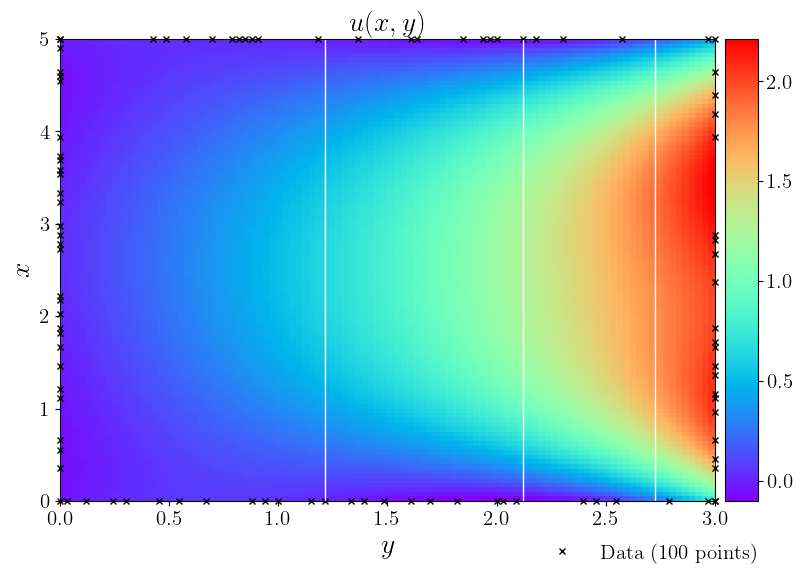

In [9]:

""" The aesthetic setting has changed. """

####### Row 0: u(t,x) ##################    

fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111)

h = ax.imshow(U_pred.T, interpolation='nearest', cmap='rainbow', 
              extent=[y.min(), y.max(), x.min(), x.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.10)
cbar = fig.colorbar(h, cax=cax)
cbar.ax.tick_params(labelsize=15) 

ax.plot(
    X_u_train[:,1], 
    X_u_train[:,0], 
    'kx', label = 'Data (%d points)' % (u_train.shape[0]), 
    markersize = 4,  # marker size doubled
    clip_on = False,
    alpha=1.0
)

line = np.linspace(x.min(), x.max(), 2)[:,None]
ax.plot(y[40]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(y[70]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(y[90]*np.ones((2,1)), line, 'w-', linewidth = 1)

ax.set_xlabel('$y$', size=20)
ax.set_ylabel('$x$', size=20)
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.9, -0.05), 
    ncol=5, 
    frameon=False, 
    prop={'size': 15}
)
ax.set_title('$u(x,y)$', fontsize = 20) # font size doubled
ax.tick_params(labelsize=15)
plt.savefig("laplace_forword.pdf", format="pdf")

plt.show()